## Dependencies

In [1]:
import gc
import re
import warnings
from joblib import dump
import tensorflow_hub as hub
from tensorflow.keras import Model, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout, Concatenate, BatchNormalization, Activation, Average, Add, Reshape
from tensorflow.keras.layers import GlobalAveragePooling1D, Embedding, LSTM, Conv1D, SpatialDropout1D, Bidirectional, Flatten, Bidirectional
from googleqa_utilityscript import *


SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## Load data

In [2]:
module_url = '/kaggle/input/universalsentenceencodermodels/universal-sentence-encoder-models/use'
model_path = '/kaggle/working/model.h5'
tokenizer_path = '/kaggle/working/tokenizer.joblib'
encoder_path = '/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl'

hold_out = pd.read_csv('/kaggle/input/googleqa-mldataset/hold-out.csv')
test = pd.read_csv('/kaggle/input/google-quest-challenge/test.csv')
train = hold_out[hold_out['set'] == 'train']
validation = hold_out[hold_out['set'] == 'validation']

print('Train samples: %s' % len(train))
print('Validation samples: %s' % len(validation))
display(train.head())

Train samples: 4863
Validation samples: 1216


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,set
0,3895,Magento (1.7) Bundled Product with FREE Produc...,I'm looking to create a bundle offer where cus...,Joe,https://magento.stackexchange.com/users/16572,"Since the third item is fixed, you can use sho...",Fabian Schmengler,https://magento.stackexchange.com/users/243,http://magento.stackexchange.com/questions/668...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,1.000000,0.000000,0.333333,0.888889,train
1,3131,Find router on network,I've just bought a Belkin N+ Wireless Router. ...,Guy,https://superuser.com/users/3248,You likely have the router plugged in to the m...,John T,https://superuser.com/users/1931,http://superuser.com/questions/87212,TECHNOLOGY,...,1.000000,0.666667,1.0,1.0,0.866667,0.666667,0.000000,1.000000,1.000000,train
2,1507,Negatively curved metrics minimizing the lengt...,Good afternoon everyone !\n\nI have the follow...,Selim G,https://mathoverflow.net/users/25511,A very partial answer: by the results of Richa...,Igor Rivin,https://mathoverflow.net/users/11142,http://mathoverflow.net/questions/203422,SCIENCE,...,0.888889,0.333333,1.0,1.0,0.700000,0.333333,0.333333,1.000000,0.888889,train
3,6784,Isn’t the FAQ label obsolete by now?,Don’t get me wrong in the beginning of reading...,Benny Skogberg,https://ux.stackexchange.com/users/4679,Isn’t the FAQ label obsolete by now? \n\nI'd s...,Solracnapod,https://ux.stackexchange.com/users/13153,http://ux.stackexchange.com/questions/18600/is...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,0.000000,0.000000,0.666667,1.000000,train
4,2135,Changing background image one time on responsi...,The code I'm using is this one \n\nbackground:...,user2141649,https://stackoverflow.com/users/2141649,&lt;!DOCTYPE html&gt;\n&lt;html&gt;\n&lt;head&...,akkimads,https://stackoverflow.com/users/2375373,http://stackoverflow.com/questions/16359492/ch...,STACKOVERFLOW,...,0.888889,0.500000,1.0,1.0,0.800000,1.000000,0.000000,0.000000,0.777778,train


In [3]:
question_target_cols = ['question_asker_intent_understanding','question_body_critical', 'question_conversational', 
                        'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer',
                        'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 
                        'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice',
                        'question_type_compare', 'question_type_consequence', 'question_type_definition', 
                        'question_type_entity', 'question_type_instructions', 'question_type_procedure',
                        'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']
answer_target_cols = ['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance',
                      'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 
                      'answer_type_reason_explanation', 'answer_well_written']
target_cols = question_target_cols + answer_target_cols

## Pre-process data

In [4]:
text_features = ['question_title', 'question_body', 'answer']

for feature in text_features:
    # Lower
    train[feature] = train[feature].apply(lambda x: x.lower())
    validation[feature] = validation[feature].apply(lambda x: x.lower())
    test[feature] = test[feature].apply(lambda x: x.lower())
    # Map contractions
    train[feature] = train[feature].apply(lambda x: map_contraction(x))
    validation[feature] = validation[feature].apply(lambda x: map_contraction(x))
    test[feature] = test[feature].apply(lambda x: map_contraction(x))
    # Trim text
    train[feature] = train[feature].apply(lambda x: x.strip())
    validation[feature] = validation[feature].apply(lambda x: x.strip())
    test[feature] = test[feature].apply(lambda x: x.strip())

for feature in text_features:
    train[feature + '_uncased'] = train[feature]
    validation[feature + '_uncased'] = validation[feature]
    test[feature + '_uncased'] = test[feature]

In [5]:
def split_paragraphs(row):
    splited_body = re.split('\n\n\n\n\n|\n\n\n\n|\n\n\n|\n\n', row['question_body_uncased'])
    splited_answer = re.split('\n\n\n\n\n|\n\n\n\n|\n\n\n|\n\n', row['answer_uncased'])
    for i in range(len(splited_body))[:10]:
        row['body_paragraph_%s' % (i+1)] = splited_body[i]
    for i in range(len(splited_answer))[:10]:
        row['answer_paragraph_%s' % (i+1)] = splited_answer[i]
    return row

train = train.apply(split_paragraphs, axis=1)
validation = validation.apply(split_paragraphs, axis=1)

# Model parameters

In [6]:
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 3e-4
EMBEDDDING_SIZE = 512
N_CLASS = len(target_cols)
ES_PATIENCE = 5
RLROP_PATIENCE = 2
DECAY_DROP = 0.3
MAX_FEATURES = 100000
TITLE_MAX_LEN = 30
BODY_MAX_LEN = 30
ANSWER_MAX_LEN = 30

In [7]:
tokenizer = Tokenizer(num_words=MAX_FEATURES, lower=True)

tokenizer.fit_on_texts(list(train['question_title_uncased']) + list(validation['question_title_uncased']) + list(test['question_title_uncased']) +
                       list(train['question_body_uncased']) + list(validation['question_body_uncased']) + list(test['question_body_uncased']) +
                       list(train['answer_uncased']) + list(validation['answer_uncased']) + list(test['answer_uncased']))

## Train/validation sets

In [8]:
body_ft = ['body_paragraph_1', 'body_paragraph_2', 'body_paragraph_3', 'body_paragraph_4', 'body_paragraph_5', 
           'body_paragraph_6', 'body_paragraph_7', 'body_paragraph_8', 'body_paragraph_9', 'body_paragraph_10']
answer_ft = ['answer_paragraph_1', 'answer_paragraph_2', 'answer_paragraph_3', 'answer_paragraph_4', 'answer_paragraph_5', 
             'answer_paragraph_6', 'answer_paragraph_7', 'answer_paragraph_8', 'answer_paragraph_9', 'answer_paragraph_10']

# Train features
X_train_title_seq = train['question_title_uncased']
X_train_body_fts = train[body_ft].astype(str)
X_train_answer_fts = train[answer_ft].astype(str)

# Tokenize the sentences
X_train_title_seq = tokenizer.texts_to_sequences(X_train_title_seq)
for ft in body_ft:
    X_train_body_fts[ft] = tokenizer.texts_to_sequences(X_train_body_fts[ft])
for ft in answer_ft:
    X_train_answer_fts[ft] = tokenizer.texts_to_sequences(X_train_answer_fts[ft])

X_train_body_seq = np.empty((X_train_body_fts.shape[0], BODY_MAX_LEN, X_train_body_fts.shape[1]))
X_train_answer_seq = np.empty((X_train_answer_fts.shape[0], ANSWER_MAX_LEN, X_train_answer_fts.shape[1]))

# Pad the sentences
X_train_title_seq = pad_sequences(X_train_title_seq, maxlen=TITLE_MAX_LEN)
for index, ft in enumerate(body_ft):
    X_train_body_seq[...,index] = pad_sequences(X_train_body_fts[ft], maxlen=BODY_MAX_LEN)
for index, ft in enumerate(answer_ft):
    X_train_answer_seq[...,index] = pad_sequences(X_train_answer_fts[ft], maxlen=ANSWER_MAX_LEN)
    
X_train = [X_train_title_seq, X_train_body_seq, X_train_answer_seq]
Y_train = train[target_cols].values

# Validation features
X_valid_title_seq = validation['question_title_uncased']
X_valid_body_fts = validation[body_ft].astype(str)
X_valid_answer_fts = validation[answer_ft].astype(str)

# Tokenize the sentences
X_valid_title_seq = tokenizer.texts_to_sequences(X_valid_title_seq)
for ft in body_ft:
    X_valid_body_fts[ft] = tokenizer.texts_to_sequences(X_valid_body_fts[ft])
for ft in answer_ft:
    X_valid_answer_fts[ft] = tokenizer.texts_to_sequences(X_valid_answer_fts[ft])

X_valid_body_seq = np.empty((X_valid_body_fts.shape[0], BODY_MAX_LEN, X_valid_body_fts.shape[1]))
X_valid_answer_seq = np.empty((X_valid_answer_fts.shape[0], ANSWER_MAX_LEN, X_valid_answer_fts.shape[1]))

# Pad the sentences
X_valid_title_seq = pad_sequences(X_valid_title_seq, maxlen=TITLE_MAX_LEN)
for index, ft in enumerate(body_ft):
    X_valid_body_seq[...,index] = pad_sequences(X_valid_body_fts[ft], maxlen=BODY_MAX_LEN)
for index, ft in enumerate(answer_ft):
    X_valid_answer_seq[...,index] = pad_sequences(X_valid_answer_fts[ft], maxlen=ANSWER_MAX_LEN)

X_valid = [X_valid_title_seq, X_valid_body_seq, X_valid_answer_seq]
Y_valid = validation[target_cols].values


print('Train samples: %d' % len(Y_train))
print('Validation samples: %d' % len(Y_valid))

Train samples: 4863
Validation samples: 1216


# Model

In [9]:
# use_embed = hub.load(module_url)

# def USEEmbedding(x):
#     return use_embed(tf.squeeze(tf.cast(x, tf.string)))

def encoder_block(input_layer):
    encoder = Lambda(USEEmbedding, output_shape=(EMBEDDDING_SIZE,))(input_layer)
    
    return encoder

def encoder_block_parag(input_layer, index, name_pre):
    name = '%s_parag_%d' % (name_pre, index)
    encoder = Embedding(*glove_embedding_matrix.shape, weights=[glove_embedding_matrix], trainable=False, name='enc_'+name)(input_layer[...,index])
    encoder = SpatialDropout1D(0.2)(encoder)
    encoder = LSTM(64, kernel_initializer='lecun_normal', recurrent_dropout=0.5, return_sequences=False)(encoder)

    return encoder

## Load embedding

In [10]:
glove_embedding_matrix, glove_unknown_words = build_matrix(tokenizer.word_index, encoder_path, MAX_FEATURES)
embedding_name = 'GloVe'
print('n unknown words "%s": %d' % (embedding_name, len(glove_unknown_words)))
print('"%s" embedding shape: %s' % (embedding_name, glove_embedding_matrix.shape))

n unknown words "GloVe": 19913
"GloVe" embedding shape: (58007, 300)


In [11]:
# Title sequence
input_title_seq = Input(shape=(TITLE_MAX_LEN,), dtype=tf.float32, name='input_title_seq')
title = Embedding(*glove_embedding_matrix.shape, weights=[glove_embedding_matrix], trainable=False)(input_title_seq)
title = SpatialDropout1D(0.2)(title)
title = LSTM(128, kernel_initializer='lecun_normal', recurrent_dropout=0.5, return_sequences=True)(title)
title_out = GlobalAveragePooling1D()(title)

# Body sequence
input_body_seq = Input(shape=(*X_train_body_seq.shape[1:], ), dtype=tf.float32, name='input_body_seq')

body1_out = encoder_block_parag(input_body_seq, 0, 'body')
body2_out = encoder_block_parag(input_body_seq, 1, 'body')
body3_out = encoder_block_parag(input_body_seq, 2, 'body')
body4_out = encoder_block_parag(input_body_seq, 3, 'body')
body5_out = encoder_block_parag(input_body_seq, 4, 'body')
body6_out = encoder_block_parag(input_body_seq, 5, 'body')
body7_out = encoder_block_parag(input_body_seq, 6, 'body')
body8_out = encoder_block_parag(input_body_seq, 7, 'body')
body9_out = encoder_block_parag(input_body_seq, 8, 'body')
body10_out = encoder_block_parag(input_body_seq, 9, 'body')


# Answer sequence
input_answer_seq = Input(shape=(*X_train_body_seq.shape[1:], ), dtype=tf.float32, name='input_answer_seq')

answer1_out = encoder_block_parag(input_answer_seq, 0, 'answer')
answer2_out = encoder_block_parag(input_answer_seq, 1, 'answer')
answer3_out = encoder_block_parag(input_answer_seq, 2, 'answer')
answer4_out = encoder_block_parag(input_answer_seq, 3, 'answer')
answer5_out = encoder_block_parag(input_answer_seq, 4, 'answer')
answer6_out = encoder_block_parag(input_answer_seq, 5, 'answer')
answer7_out = encoder_block_parag(input_answer_seq, 6, 'answer')
answer8_out = encoder_block_parag(input_answer_seq, 7, 'answer')
answer9_out = encoder_block_parag(input_answer_seq, 8, 'answer')
answer10_out = encoder_block_parag(input_answer_seq, 9, 'answer')


# Output
x = Concatenate()([title_out, body1_out, body2_out, body3_out, body4_out, body5_out, body6_out, body7_out, body8_out, body9_out, body10_out, answer1_out, answer2_out, answer3_out, answer4_out, answer5_out, answer6_out, answer7_out, answer8_out, answer9_out, answer10_out])
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_initializer='lecun_normal')(x)
x = Dropout(0.5)(x)

output = Dense(N_CLASS, activation='sigmoid', kernel_initializer='lecun_normal', name='output')(x)
model = Model(inputs=[input_title_seq, input_body_seq, input_answer_seq], outputs=[output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_title_seq (InputLayer)    [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_body_seq (InputLayer)     [(None, 30, 10)]     0                                            
__________________________________________________________________________________________________
input_answer_seq (InputLayer)   [(None, 30, 10)]     0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 300)      17402100    input_title_seq[0][0]            
______________________________________________________________________________________________

# Train model

In [12]:
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-7, verbose=1)
spearmanCallback = SpearmanRhoCallback(training_data=(X_train, Y_train), validation_data=(X_valid, Y_valid), monitor='val_loss', mode='min', patience=ES_PATIENCE)
callback_list = [rlrop, spearmanCallback]

optimizer = optimizers.Adam(LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

history = model.fit(X_train, Y_train, 
                    validation_data=(X_valid, Y_valid), 
                    callbacks=callback_list, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    verbose=2).history

Train on 4863 samples, validate on 1216 samples
Epoch 1/50
spearman-rho: 0.2334 val_spearman-rho: 0.2235
4863/4863 - 207s - loss: 0.4516 - val_loss: 0.4142
Epoch 2/50
spearman-rho: 0.2785 val_spearman-rho: 0.2586
4863/4863 - 139s - loss: 0.4144 - val_loss: 0.4052
Epoch 3/50
spearman-rho: 0.3054 val_spearman-rho: 0.2777
4863/4863 - 140s - loss: 0.4061 - val_loss: 0.4012
Epoch 4/50
spearman-rho: 0.3260 val_spearman-rho: 0.2877
4863/4863 - 139s - loss: 0.4021 - val_loss: 0.3987
Epoch 5/50
spearman-rho: 0.3414 val_spearman-rho: 0.2951
4863/4863 - 140s - loss: 0.3979 - val_loss: 0.3975
Epoch 6/50
spearman-rho: 0.3590 val_spearman-rho: 0.3000
4863/4863 - 138s - loss: 0.3937 - val_loss: 0.3952
Epoch 7/50
spearman-rho: 0.3735 val_spearman-rho: 0.3057
4863/4863 - 138s - loss: 0.3903 - val_loss: 0.3934
Epoch 8/50
spearman-rho: 0.3874 val_spearman-rho: 0.3085
4863/4863 - 139s - loss: 0.3867 - val_loss: 0.3921
Epoch 9/50
spearman-rho: 0.4019 val_spearman-rho: 0.3128
4863/4863 - 139s - loss: 0.3840

## Model loss graph

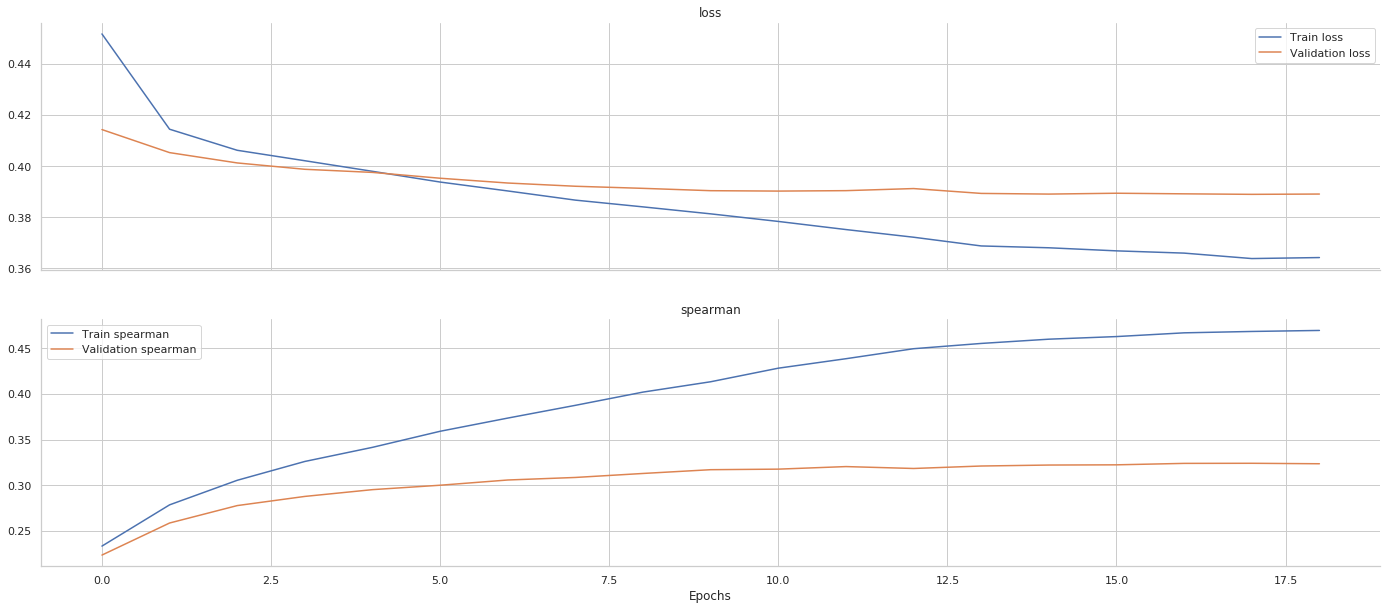

In [13]:
sns.set(style="whitegrid")
plot_metrics(history, metric_list=['loss', 'spearman'])

# Evaluation

In [14]:
preds_train = model.predict(X_train)
preds_val = model.predict(X_valid)

display(get_metrics(Y_train, preds_train, Y_valid, preds_val, target_cols).style.applymap(color_map))

,Label,Train,Validation
0,Averaged,0.469,0.324
1,question_asker_intent_understanding,0.432,0.372
2,question_body_critical,0.659,0.567
3,question_conversational,0.448,0.387
4,question_expect_short_answer,0.512,0.169
5,question_fact_seeking,0.572,0.296
6,question_has_commonly_accepted_answer,0.583,0.387
7,question_interestingness_others,0.39,0.37
8,question_interestingness_self,0.524,0.456
9,question_multi_intent,0.547,0.33


## By category

In [15]:
target_cols_preds = [col+'_pred' for col in target_cols]
for col in target_cols_preds:
    train[col] = 0
    validation[col] = 0
    
train[target_cols_preds] = preds_train
validation[target_cols_preds] = preds_val
    
display(get_metrics_category(train, validation, target_cols, target_cols_preds, 'category').style.applymap(color_map))

,Label,Train (TECHNOLOGY),Validation (TECHNOLOGY),Train (SCIENCE),Validation (SCIENCE),Train (STACKOVERFLOW),Validation (STACKOVERFLOW),Train (LIFE_ARTS),Validation (LIFE_ARTS),Train (CULTURE),Validation (CULTURE)
0,Averaged,0.45,0.281,0.479,0.302,0.406,0.185,0.457,0.333,0.432,0.302


#### Save model weights and ecoders

In [16]:
model.save_weights(model_path)
dump(tokenizer, tokenizer_path)

['/kaggle/working/tokenizer.joblib']